In [1]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import time
import datetime
from datetime import datetime, date
from datetime import timedelta
import talib
import pickle
from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
#from xgboost import XGB
from xgboost import XGBClassifier
from xgboost import DMatrix
import lightgbm as lgb
from scipy.signal import argrelextrema
import pytz

In [2]:
from_date = date(2013,1,1)
to_date=datetime.now()

start= time.mktime(from_date.timetuple())
end = time.mktime(to_date.timetuple())

tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT',
 'USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG',
           'USDT_XTZ','USDT_BSV','USDT_MKR','USDT_ZRX','USDT_VET','USDT_BTG','USDT_ZIL']#bitfinex

def get_data(date,coin):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histohour?fsym="+coin+"&tsym=USD&limit=1000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_hourly(date,coin, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=USD&limit=999&toTs={}'\
            .format(date)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()#['Data']
    #df = pd.DataFrame(data)
    #df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return data


def get_df(from_date, to_date,coin):
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=True, inplace=True)
    df.to_csv("1h_"+coin + '.csv')
    print('Processed: ' + coin)
    return df

def coin_metrics(cap,coin,start,end):#used to get market cap and total volume
    if cap=='cap':
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/marketcap(usd)/'+str(start)+'/'+str(end)
    else:
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/exchangevolume(usd)/'+str(start)+'/'+str(end)

    r=requests.get(url)
    ipdata = r.json()
    ipdata['result']
    cap=pd.DataFrame(ipdata['result'],columns=['date','cap'])
    date=[]
    for i in cap.date:
        date.append(pd.to_datetime(datetime.fromtimestamp(i)))
    cap.index=date
    cap=cap.resample('1H').ffill()
    return cap['cap']

#for x in tickers:
#    get_df(start,end,x[5:])

get_df(start,end,'BTC').tail()

Processed: BTC


,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-05-15 16:00:00,7997.40,8037.3,7910.1,8005.50,704.73,5624761.05
2019-05-15 17:00:00,8077.96,8114.4,7980.0,7997.40,1015.06,8182756.02
2019-05-15 18:00:00,8182.00,8192.0,8055.0,8077.96,2156.27,17530696.99
2019-05-15 19:00:00,8164.70,8199.0,8055.0,8182.00,912.16,7435726.53
2019-05-15 20:00:00,8166.90,8199.9,8144.2,8164.70,307.32,2514320.36


In [3]:
def divergence(close,RSI,lookback,window,maxx,low):
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z])  
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    return bull_div,bear_div

def bbp(price):
    up, mid, low = talib.BBANDS(price, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price - low) / (up - low)
    return bbp

In [4]:
def retrieve_symbol_name(coin,window):
    col=['date','close']
    ndf=pd.read_csv("1h_"+coin+'.csv',index_col='time')
    ndf.index=pd.to_datetime(ndf.index)
    ndf=ndf.loc[(ndf!=0).any(axis=1)]
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf=ndf.drop_duplicates()
    ndf=ndf.resample('1H').ffill()
    pdf=pd.DataFrame(ndf).copy()
    pdf['1_day_high']=ndf['high'].rolling(24).max()
    pdf['1_day_low']=ndf['low'].rolling(24).min()
    new_index=pdf.index-timedelta(hours=24)
    pdf.index=new_index
    ndf['1day_high']=pdf['1_day_high']
    ndf['1day_low']=pdf['1_day_low']
    ndf['exit']=pdf['close']
    df=pd.DataFrame(ndf).copy()
    df['returns']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,40)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    #df['hid_bull_div']=0
    #df['hid_bull_div'].iloc[div[2]]=1
    #df['hid_bear_div']=0
    #df['hid_bear_div'].iloc[div[3]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['600_var']=df['var'].rolling(600).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['600_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)

    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>=df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>=df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    df['Pnl_Long']=((df['exit']-df['close'])/df['close'])*100
    df['Pnl_Short']=df['Pnl_Long']*-1
    df=df.dropna()
    df=df.resample('1H').ffill()
    return df

def all_coins():
    start=time.time()
    df=retrieve_symbol_name('BTC',14)
    for x in tickers[1:]:
        print(x)
        df=df.append(retrieve_symbol_name(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

df=all_coins()

#pickle the dataframe
filename = '1hr_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()



C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


USDT_ETC
USDT_EOS
USDT_XMR
USDT_ETH
USDT_DASH
USDT_BAT
USDT_GNT
USDT_XRP
USDT_LTC
USDT_XLM
USDT_REP
USDT_ZEC
USDT_IOT
USDT_NEO
USDT_BCH
USDT_TRX
USDT_OMG
USDT_XTZ
USDT_BSV
USDT_MKR
USDT_ZRX
USDT_VET
USDT_BTG
USDT_ZIL
Runtime is 29.479849100112915 seconds


In [5]:
#load dataframe
filename = '1hr_df'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()
df=df.drop_duplicates()


In [6]:
def entry_filter_long(df): # after this run the train split part
    df3=df.loc[(df['RSI_up']<1)].copy()# basic entry signal
    df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    df3['label']=(df3['max_return']>0.05).astype(int)#trying to identify trades who have bigger potential
    return df3

def entry_filter_short(df):
    df3=df.loc[(df['BB']>.7)].copy()
    df3['max_return']=(df3['close']-df3['1day_low'])/df3['close']
    df3['label']=(df3['max_return']>0.05).astype(int)
    return df3

#entry=entry_filter_short(df)
entry=entry_filter_long(df)


features=df.columns[3:]
features=list(features)
x=['coin','Pnl_Long','Pnl_Short']
features=[e for e in features if e not in x]


print('Percent of Target Trades:', 100*(entry.label.sum()) / float(len(entry)))
len(entry)

Percent of Target Trades: 32.69815098339418


169820

In [7]:

### Split the data into training, testing sets
train = entry[(pd.to_datetime(entry.index) < pd.to_datetime('2018-12-01')) & 
           (pd.to_datetime(entry.index) >= pd.to_datetime('2013-01-01'))]
test = entry[pd.to_datetime(entry.index) >= pd.to_datetime('2018-12-01')]
X_train = train.loc[:,features]
y_train = train.loc[:,'label']
X_test = test.loc[:,features]
y_test = test.loc[:,'label']

X = entry.loc[:,features]
Y=entry.loc[:,'label']

print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))
    


Length of Training Set: 131461
Length of Testing Set: 38359


In [8]:
#optimise hyperparameters, choose set with lowest log_loss
log_losses={}

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

for n in range(100,400,100):
    for md in range(1,7):
        for mln in range(50,400,100):
            for nl in range(10,20,10):
                for lr in frange(.01,.2,.05):
                    param = {'max_depth':md, 'num_leaves':nl, 'learning_rate':lr, 'num_trees':n,'num_threads':-1,
         'min_data_in_leaf':mln, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
                    data = lgb.Dataset(X_train, y_train)
                    bst=lgb.train(param, data)
                    y_pred=bst.predict(X_test)
                    sc=log_loss(y_test,y_pred)
                    log_losses[str(n)+'_'+str(md)+'_'+str(mln)+'_'+str(nl)+'_'+str(lr)]=sc
                    
                        

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_tr

In [9]:
def optimal_param(data):
    df=pd.DataFrame.from_dict(data,orient='index')
    df.columns=['score']
    df=df.reset_index()
    split = df["index"].str.split("_", n = 4, expand = True) 
    df=df.join(split,how='outer')
    df=df.iloc[:,1:]
    df.columns=['score','num_trees','max_depth','min_leaf_data','num_leaves','learning_rate']
    for i in range(1,6):
        df.iloc[:,i]=pd.to_numeric(df.iloc[:,i])
    df=df.round(4)
    df=df.sort_values(by=['score'])
    return df

opt=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param'
outfile = open(filename,'wb')
pickle.dump(opt,outfile)
outfile.close()
opt.head()


,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
275,0.5002,300,6,50,10,0.16
271,0.5066,300,5,350,10,0.16
267,0.5075,300,5,250,10,0.16
247,0.5105,300,4,150,10,0.16
283,0.5122,300,6,250,10,0.16


In [10]:
#load optimal long parameters
filename = 'opt_param'
infile = open(filename,'rb')
opt = pickle.load(infile)
infile.close()
opt.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
275,0.5002,300,6,50,10,0.16
271,0.5066,300,5,350,10,0.16
267,0.5075,300,5,250,10,0.16
247,0.5105,300,4,150,10,0.16
283,0.5122,300,6,250,10,0.16


In [11]:
opt_short=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param_short'
outfile = open(filename,'wb')
pickle.dump(opt_short,outfile)
outfile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
275,0.5002,300,6,50,10,0.16
271,0.5066,300,5,350,10,0.16
267,0.5075,300,5,250,10,0.16
247,0.5105,300,4,150,10,0.16
283,0.5122,300,6,250,10,0.16


In [12]:
#load optimal short parameters
filename = 'opt_param_short'
infile = open(filename,'rb')
opt_short = pickle.load(infile)
infile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
275,0.5002,300,6,50,10,0.16
271,0.5066,300,5,350,10,0.16
267,0.5075,300,5,250,10,0.16
247,0.5105,300,4,150,10,0.16
283,0.5122,300,6,250,10,0.16


In [13]:
def xgb_gbm(long,test):
    n=0
    data = lgb.Dataset(X_train, y_train)
    if long==True:
        param = {'max_depth':opt['max_depth'].iloc[n], 'num_leaves':opt['num_leaves'].iloc[n], 'learning_rate':opt['learning_rate'].iloc[n], 'num_trees':opt['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    else:
        param = {'max_depth':opt_short['max_depth'].iloc[n], 'num_leaves':opt_short['num_leaves'].iloc[n], 'learning_rate':opt_short['learning_rate'].iloc[n], 'num_trees':opt_short['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt_short['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    
    bst = lgb.train(param, data)
    y_pred = bst.predict(X_test)
    
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred >0.5]
    if long==True:
        trades['cpl'] = trades.Pnl_Long.cumsum()
        test['cpl'] = test.Pnl_Long.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_long'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()

    
    else:
        trades['cpl'] = trades.Pnl_Short.cumsum()
        test['cpl'] = test.Pnl_Short.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_short'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()
    return test,trades,y_pred
    

#test=xgb_gbm(False,test)[0]
#trades=xgb_gbm(False,test)[1]

test=xgb_gbm(True,test)[0]
trades=xgb_gbm(True,test)[1]


'Predicted trades '+str((xgb_gbm(True,test)[2].sum())/len(test))+'  :  Actual trades '+str((test.label.sum())/len(test))

C:\Users\Jens\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jens\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'Predicted trades 0.3670843003167543  :  Actual trades 0.30441356656847157'

In [14]:
def drawdowns(equity_curve):
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max()#, duration

def stats_v2(trades,y_pred,prob):
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    col=['Mean_Return','Std','Count','Total','Sharpe']
    df=[trades.Pnl.mean(),trades.Pnl.std(),len(trades),trades.Pnl.sum(),trades.Pnl.mean()/trades.Pnl.std()]
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    return df

def stats(trades,test,y_pred,prob,t,direction):
    #trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    if direction=='long':
        ret=trades.Pnl_Long
        bench=test.Pnl_Long
    else:
        ret=trades.Pnl_Short
        bench=test.Pnl_Short
    
    neg1=bench[bench<0]
    neg=ret[ret<0]
    col=['Mean_Return','Std','Count','Total','Sharpe','Sortino','Calmar','1day_Calmar']
    df=[ret.mean(),ret.std(),len(trades),ret.sum(),ret.mean()/ret.std(),ret.mean()/neg.std(),trades.cpl.max()/drawdowns(trades.cpl),ret.mean()/abs(ret.min())]
    df1=[bench.mean(),bench.std(),len(test),bench.sum(),bench.mean()/bench.std(),ret.mean()/neg1.std(),test.cpl.max()/drawdowns(test.cpl),bench.mean()/abs(bench.min())]
    df1=pd.DataFrame(df1)
    df1=df1.transpose()
    df1.columns=col
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    if t=='base':
        df=df.append(df1)
        df.index=['ML','Basic']
    return df

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def opt_prob(direction):
    p=.5
    prob=[p]
    df=stats(trades,test,y_pred,p,'t',direction)  
    for x in frange(.55,trades.pred.max(),.05):
        try:
            df=df.append(stats(trades,test,y_pred,x,'t',direction))
            prob.append(x)
        except:
            break
            
    df.index=prob
    return df


res=opt_prob('long')
res


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,3.196943,7.145258,10196.0,32596.030639,0.447422,0.864328,11.971680,0.135116
0.55,3.610984,7.412958,8254.0,29805.064351,0.487118,0.940850,11.971680,0.152615
0.60,4.075160,7.761840,6500.0,26488.540490,0.525025,1.029689,11.971680,0.172233
0.65,4.509874,8.217367,4988.0,22495.250417,0.548822,1.092946,11.966909,0.190606
0.70,5.175293,8.788506,3703.0,19164.111430,0.588871,1.175829,11.990213,0.218729
0.75,5.940867,9.358426,2649.0,15737.356975,0.634815,1.322059,12.008191,0.251086
0.80,6.708486,10.229456,1836.0,12316.781066,0.655801,1.365733,12.007601,0.283528
0.85,8.100172,11.250268,1140.0,9234.195738,0.719998,1.615347,12.141005,0.390608
0.90,9.307924,12.832203,561.0,5221.745324,0.725357,1.751006,12.166157,0.448849
0.95,14.468794,17.576986,151.0,2184.787866,0.823167,2.584985,16.381480,0.825462


In [15]:
res=opt_prob('long')
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,3.196943,7.145258,10196.0,32596.030639,0.447422,0.864328,11.971680,0.135116
0.55,3.610984,7.412958,8254.0,29805.064351,0.487118,0.940850,11.971680,0.152615
0.60,4.075160,7.761840,6500.0,26488.540490,0.525025,1.029689,11.971680,0.172233
0.65,4.509874,8.217367,4988.0,22495.250417,0.548822,1.092946,11.966909,0.190606
0.70,5.175293,8.788506,3703.0,19164.111430,0.588871,1.175829,11.990213,0.218729
0.75,5.940867,9.358426,2649.0,15737.356975,0.634815,1.322059,12.008191,0.251086
0.80,6.708486,10.229456,1836.0,12316.781066,0.655801,1.365733,12.007601,0.283528
0.85,8.100172,11.250268,1140.0,9234.195738,0.719998,1.615347,12.141005,0.390608
0.90,9.307924,12.832203,561.0,5221.745324,0.725357,1.751006,12.166157,0.448849
0.95,14.468794,17.576986,151.0,2184.787866,0.823167,2.584985,16.381480,0.825462


In [16]:
res=opt_prob('short')#BB >.8
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,-3.196943,7.145258,10196.0,-32596.030639,-0.447422,-0.522878,11.971680,-0.045845
0.55,-3.610984,7.412958,8254.0,-29805.064351,-0.487118,-0.565047,11.971680,-0.051782
0.60,-4.075160,7.761840,6500.0,-26488.540490,-0.525025,-0.602646,11.971680,-0.058439
0.65,-4.509874,8.217367,4988.0,-22495.250417,-0.548822,-0.625464,11.966909,-0.064672
0.70,-5.175293,8.788506,3703.0,-19164.111430,-0.588871,-0.666269,11.990213,-0.074215
0.75,-5.940867,9.358426,2649.0,-15737.356975,-0.634815,-0.712211,12.008191,-0.085193
0.80,-6.708486,10.229456,1836.0,-12316.781066,-0.655801,-0.728998,12.007601,-0.096201
0.85,-8.100172,11.250268,1140.0,-9234.195738,-0.719998,-0.787093,12.141005,-0.116158
0.90,-9.307924,12.832203,561.0,-5221.745324,-0.725357,-0.779537,12.166157,-0.133477
0.95,-14.468794,17.576986,151.0,-2184.787866,-0.823167,-0.849759,16.381480,-0.207485


In [17]:
res=opt_prob('short')#BB>.7
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,-3.196943,7.145258,10196.0,-32596.030639,-0.447422,-0.522878,11.971680,-0.045845
0.55,-3.610984,7.412958,8254.0,-29805.064351,-0.487118,-0.565047,11.971680,-0.051782
0.60,-4.075160,7.761840,6500.0,-26488.540490,-0.525025,-0.602646,11.971680,-0.058439
0.65,-4.509874,8.217367,4988.0,-22495.250417,-0.548822,-0.625464,11.966909,-0.064672
0.70,-5.175293,8.788506,3703.0,-19164.111430,-0.588871,-0.666269,11.990213,-0.074215
0.75,-5.940867,9.358426,2649.0,-15737.356975,-0.634815,-0.712211,12.008191,-0.085193
0.80,-6.708486,10.229456,1836.0,-12316.781066,-0.655801,-0.728998,12.007601,-0.096201
0.85,-8.100172,11.250268,1140.0,-9234.195738,-0.719998,-0.787093,12.141005,-0.116158
0.90,-9.307924,12.832203,561.0,-5221.745324,-0.725357,-0.779537,12.166157,-0.133477
0.95,-14.468794,17.576986,151.0,-2184.787866,-0.823167,-0.849759,16.381480,-0.207485


Text(0.5, 1.0, 'Position History')

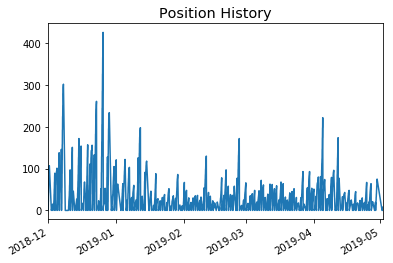

In [18]:
def trade_count(trades):#plots rolling 24hr positions
    start=trades.index[0]
    init=trades[trades.index<start+timedelta(hours=24)].copy()
    init['position']=np.arange(len(init))
    end=trades.index[-1]
    #trades['positions']=0
    for i in  range(1,(end-start).days):
        s=start+timedelta(hours=(24*i))
        e=start+timedelta(hours=(24*i+24))
        one_day=trades[(trades.index>s)&(trades.index<e)].copy()
        one_day['position']=np.arange(len(one_day))
        init=init.append(one_day)
    return init


d=trade_count(trades)  
d.position.plot()
style.use("ggplot")
plt.rcParams["figure.figsize"]=[16,9]
plt.title("Position History")

In [19]:
trades

,close,high,low,open,volumeto,1day_high,1day_low,exit,returns,coin,...,Market_Cap,Total_vol,vol/cap,Total_vol/cap,Pnl_Long,Pnl_Short,max_return,label,cpl,pred
time,,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:00,1.52000,1.53000,1.49000,1.52000,9992.20,1.69000,1.48000,1.66000,0.000000,OMG,...,2.113648e+08,2.076896e+07,4.727465e-05,0.098261,9.210526,-9.210526,0.111842,1,9.210526,0.518941
2018-12-01 00:00:00,7.71000,7.75000,7.66000,7.75000,61475.23,8.50000,7.53000,8.43000,-0.005161,NEO,...,5.021662e+08,1.510810e+08,1.224201e-04,0.300859,9.338521,-9.338521,0.102464,1,18.549048,0.876974
2018-12-01 00:00:00,0.15880,0.16020,0.15880,0.15890,17673.77,0.17190,0.15800,0.16850,-0.000629,XLM,...,3.047244e+09,8.308402e+07,5.799920e-06,0.027265,6.108312,-6.108312,0.082494,1,24.657360,0.712996
2018-12-01 00:00:00,0.39200,0.39540,0.39200,0.39410,2509.55,0.44050,0.38530,0.41810,-0.005329,ZRX,...,2.152177e+08,1.040395e+07,1.166052e-05,0.048342,6.658163,-6.658163,0.123724,1,31.315523,0.604245
2018-12-01 00:00:00,0.16530,0.16940,0.16300,0.16800,976.36,0.18280,0.16300,0.17990,-0.016071,BAT,...,1.986305e+08,4.763369e+06,4.915459e-06,0.023981,8.832426,-8.832426,0.105868,1,40.147949,0.566936
2018-12-01 00:00:00,8.18000,8.18000,8.18000,8.18000,0.00,8.90000,8.18000,8.90000,0.000000,REP,...,9.017113e+07,1.122270e+06,0.000000e+00,0.012446,8.801956,-8.801956,0.088020,1,48.949905,0.882407
2018-12-01 00:00:00,80.97000,81.98000,80.01000,81.47000,114595.32,86.68000,78.50000,81.12000,-0.006137,ZEC,...,4.321746e+08,2.078420e+08,2.651598e-04,0.480921,0.185254,-0.185254,0.070520,1,49.135159,0.643804
2018-12-01 00:00:00,32.12000,32.28000,31.90000,32.20000,129831.54,35.48000,31.50000,34.87000,-0.002484,LTC,...,1.908220e+09,4.282862e+08,6.803802e-05,0.224443,8.561644,-8.561644,0.104608,1,57.696803,0.623659
2018-12-01 00:00:00,92.56000,92.62000,91.65000,92.50000,17632.06,99.80000,90.74000,96.74000,0.000649,DASH,...,7.802379e+08,1.832212e+08,2.259831e-05,0.234827,4.515990,-4.515990,0.078220,1,62.212792,0.623199


In [20]:

print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

Original PnL - No ML


KeyError: "None of [DatetimeIndex(['2018-12-01 00:00:00', '2018-12-01 00:00:00',\n               '2018-12-01 00:00:00', '2018-12-01 00:00:00',\n               '2018-12-01 00:00:00', '2018-12-01 00:00:00',\n               '2018-12-01 00:00:00', '2018-12-01 00:00:00',\n               '2018-12-01 00:00:00', '2018-12-01 00:00:00',\n               ...\n               '2019-05-13 06:00:00', '2019-05-13 07:00:00',\n               '2019-05-13 08:00:00', '2019-05-13 09:00:00',\n               '2019-05-13 10:00:00', '2019-05-13 11:00:00',\n               '2019-05-13 12:00:00', '2019-05-13 13:00:00',\n               '2019-05-13 14:00:00', '2019-05-13 15:00:00'],\n              dtype='datetime64[ns]', name='time', length=38359, freq=None)] are in the [columns]"

In [ ]:
trades['cpl'] = trades.Pnl_Short.cumsum()

test['cpl'] = test.Pnl_Short.cumsum()
print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

In [21]:
def divergence_v2(close,RSI,lookback,window,maxx,low):
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    hid_bear_rsi=[]
    hid_bear_price=[]
    hid_bull_rsi=[]
    hid_bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
            if RSI.iloc[x]>max(RSI.iloc[max(0,x-lookback):x]):
                hid_bear_rsi.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
            if RSI.iloc[t]<min(RSI.iloc[max(0,t-lookback):t]):
                hid_bull_rsi.append(t) 
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z]) 
            if close.iloc[troughs[z]]>close.iloc[troughs[z-1]]:
                hid_bull_price.append(troughs[z]) 
    
    for t in range(1,len(peaks)):
        if RSI.iloc[peaks[t]]>maxx:
            if close.iloc[peaks[t]]<close.iloc[peaks[t-1]]:
                hid_bear_price.append(peaks[t]) 
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    dt5=set(hid_bull_rsi)
    dt6=set(hid_bull_price)
    dt7=set(hid_bear_rsi)
    dt8=set(hid_bear_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    mergedlist3=dt5.intersection(dt6)
    mergedlist3=np.array(list(mergedlist3))
    mergedlist4=dt7.intersection(dt8)
    mergedlist4=np.array(list(mergedlist4))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    hid_bull_div=np.sort(mergedlist3)
    hid_bear_div=np.sort(mergedlist4)
    return bull_div,bear_div,hid_bull_div,hid_bear_div



# from here on we start the CCXT trading part

In [22]:
import ccxt
#import ccxt.async_support as ccxt # link against the asynchronous version of ccxt
print(ccxt.__version__)

1.18.504


In [23]:
binance_key = "X1rCkHZYnKmNCB4DwQHSbGQ0ykKRKbg0hE1kvEOPPeRoZcbRSaO2XlrRB6WMYYgV"
secret_binance = "4n4YBqtOeNq1cvsQUmIhC2SiJpUrj9amcxdQ2bPjwT04da7OmKR4TqwaOdnGacU8"

In [24]:
# initializing the exchange

binance_ex = ccxt.binance ({
    'apiKey': binance_key,
    'secret': secret_binance,
    'options': { 'adjustForTimeDifference': True } # this line is crucial for binance else we're getting an error. it doesn't necessarily apply to other exchanges
})

#await binance_ex.close()


In [ ]:
await binance_ex.close()

In [ ]:
list(binance_ex.markets.keys())

In [ ]:

pd.DataFrame(binance_ex.fetch_tickers())


In [ ]:
print(binance_ex.has)

In [ ]:
binance_ex.fetchTicker('XRP/BTC', params = {})

In [ ]:
trade_history = pd.DataFrame(binance_ex.fetchClosedOrders('XRP/BTC', params = {}))
trade_history

In [ ]:
type(binance_ex.fetchBalance(params = {}))

In [ ]:
symbol = "XRP/BTC"
orderbook = binance_ex.fetch_order_book(symbol) 

In [ ]:
import pytz
import datetime as dt

def tz_from_utc_ms_ts(utc_ms_ts, tz_info=pytz.timezone('Europe/Dublin')):
    """Given millisecond utc timestamp and a timezone return dateime

    :param utc_ms_ts: Unix UTC timestamp in milliseconds
    :param tz_info: timezone info
    :return: timezone aware datetime
    """
    # convert from time stamp to datetime
    utc_datetime = dt.datetime.utcfromtimestamp(utc_ms_ts / 1000.)

    # set the timezone to UTC, and then convert to desired timezone
    return utc_datetime.replace(tzinfo=pytz.timezone('UTC')).astimezone(tz_info)

tz_dt = tz_from_utc_ms_ts(1557400500000)
print(tz_dt.strftime('%d-%m-%Y - %H:%M'))


In [ ]:
from datetime import datetime

columns = ['Date', 'Open', 'High', 'Low', 'Close','Volume']

ts = binance_ex.fetch_ohlcv('XRP/BTC','1h') # parameters are first the coin and then the timeframe, we can add '1d' for example to have daily data
ts = pd.DataFrame(ts,columns=columns)
dates = list(ts['Date'].apply(lambda t: tz_from_utc_ms_ts(t).strftime('%Y-%m-%d %H:%M:%S'))) # convert UTC miliseconds to dublin time
ts.index = dates
ts.drop(['Date'], axis=1).tail()

In [ ]:
from datetime import datetime
print(datetime.utcfromtimestamp(1557400080).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
pd.DataFrame(binance_ex.fetch_ohlcv('XRP/BTC','1h'))[0].apply(tz_from_utc_ms_ts).head()

In [38]:
def retrieve_symbol_name_v2(coin,window):
    col=['date','close']
    ndf=pd.read_csv("live_1h_"+coin+'.csv',index_col='time')
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf.index=pd.to_datetime(ndf.index)
    df=pd.DataFrame()
    unique_dates=ndf.index.drop_duplicates(keep='first')
    for i in unique_dates:
        if len(ndf.loc[i])>2:
            df=df.append(ndf.loc[i])
        else:
            df=df.append(ndf.loc[i].iloc[1,:])
    df['returns']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,30)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['1000_var']=df['var'].rolling(1000).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['1000_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)
    df.index=pd.to_datetime(df.index)
    df=df.dropna()
    hour=[]
    for i in df.index:
        hour.append(int(str(i)[11:13]))
    df['hour']=hour
    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    return df

def all_coins_live():
    start=time.time()
    df=retrieve_symbol_name_v2('BTC',14)
    for x in tickers[1:]:
        df=df.append(retrieve_symbol_name_v2(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

live=all_coins_live()

C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Jens\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
C:\Users\Jens\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Runtime is 122.68306159973145 seconds


In [53]:
#load our trained model

features=live.columns
features=list(features)
x=['coin']
features=[e for e in features if e not in x]

X_live=live.loc[:,features]

filename = 'xg_boost_long'
infile = open(filename,'rb')
bst = pickle.load(infile)
infile.close()

y_pred = bst.predict(X_live)
trades = live.assign(pred = y_pred)
trades = trades[trades.pred >0.5]

In [48]:
l

[str]

In [57]:
trades

,close,high,low,open,volumeto,returns,coin,RSI,RSI_10,RSI_50,...,Mom,Stoch_k,Stoch_d,BB,hour,Market_Cap,Total_vol,vol/cap,Total_vol/cap,pred
2019-04-23 17:00:00,0.111800,0.112000,0.111400,0.111400,420.36,0.003591,XLM,42.380578,46.832702,48.743326,...,-0.001100,17.424242,15.993266,0.114436,17,NaN,NaN,NaN,NaN,0.999989
2019-04-23 17:00:00,5.320000,5.330000,5.300000,5.320000,359594.16,0.000000,EOS,47.896561,58.292337,50.263126,...,0.040000,24.074074,15.740741,0.391407,17,NaN,NaN,NaN,NaN,0.999987
2019-04-23 17:00:00,17.330000,17.410000,17.320000,17.340000,3697.16,-0.000577,BTG,52.740288,57.504594,52.628186,...,0.120000,2.564103,13.614164,0.537403,17,NaN,NaN,NaN,NaN,0.996260
2019-04-23 17:00:00,1.430000,1.450000,1.430000,1.450000,4657.47,-0.013793,XTZ,52.143652,63.201719,57.482644,...,0.010000,19.047619,18.650794,0.454927,17,0.000000e+00,0.0,inf,NaN,0.999999
2019-04-23 17:00:00,0.095190,0.095190,0.090450,0.090450,247.17,0.052405,GNT,62.655554,64.296765,48.859668,...,0.006470,66.666667,53.309693,0.998566,17,NaN,NaN,NaN,NaN,0.999951
2019-04-23 17:00:00,57.340000,57.660000,57.190000,57.190000,8662.49,0.002623,BSV,43.240709,51.848252,49.348916,...,-0.640000,5.057308,23.663791,0.068476,17,NaN,NaN,NaN,NaN,0.988322
2019-04-23 17:00:00,0.007001,0.007017,0.006991,0.007017,111.64,-0.002280,VET,49.468362,52.405973,50.421395,...,0.000012,46.461538,40.170940,0.426987,17,0.000000e+00,0.0,inf,NaN,0.999991
2019-04-23 17:00:00,70.560000,70.810000,70.400000,70.400000,3715.36,0.002273,XMR,56.737227,61.573753,52.896458,...,1.430000,22.427793,40.575156,0.663096,17,NaN,NaN,NaN,NaN,0.993368
2019-04-23 17:00:00,70.010000,70.540000,69.990000,70.270000,3750.27,-0.003700,ZEC,51.377422,57.343686,53.356287,...,0.010000,47.855297,60.778639,0.414142,17,NaN,NaN,NaN,NaN,0.956356
2019-04-23 17:00:00,0.299700,0.304200,0.298400,0.303400,102363.50,-0.012195,IOT,34.604279,43.196811,48.421198,...,-0.010300,30.373728,42.645589,-0.165763,17,0.000000e+00,0.0,inf,NaN,1.000000
